# 主題：Tripadvisor評論情緒分析與飯店星級預測
#### 第十三組 第二次讀書會報告
組員：
N124020001 林坤郁
N124020004 陳忠泰
N124020005 陳莘惠
N124020006 張祐倫
N124020012 郭展州

<h3>分析主題：將資料集offerings.csv and reviews.csv合併起來，訓練模型能預測飯店星級，再用分類模型進行星級的分類。</h3>
<h3>一、專案背景與動機</h3>
在現今的數位時代，旅客在選擇住宿時，除了參考官方標榜的飯店星等外，往往也會參考其他使用者在評論平台上留下的評價。這些評論不僅反映出旅客的實際體驗，也隱含著對飯店品質的主觀認知與感受。因此，若能從大量使用者評論中挖掘出與星級評價相關的文字特徵，將有助於：
<ol>
<li>協助平台自動判別尚未評星的新飯店之潛在星等</li>
<li>為飯店經營者提供品質改善建議</li>
<li>提升使用者在選擇住宿時的資訊透明度</li>
</ol>

<h3>二、資料集簡介></h3>    
本研究使用兩組資料：
<ul>
<li>offering：飯店清單，共4,333家，包含飯店的基本資訊，如名稱、星等（hotel_class，0~5星）、地址、區域、網址等欄位。</li>
<li>review：評論清單，共878,561筆，包含使用者針對飯店所撰寫的評論文字、各項評分（整體、服務、清潔度等），以及評論時間與評論者資訊等。</li>
</ul>
兩者透過 offering_id 進行關聯，每筆評論對應一間飯店。

<h3>三、研究目的</h3>
本專案的核心目標是 透過文字探勘與機器學習技術，分析使用者評論與飯店星等的關聯性，並建構能夠預測新飯店星等的模型。
具體探討包含：
<ol>
<li>詞彙與星等的關聯分析：找出各星等（0~5星）中最具代表性的詞彙與敘述方式，分析其情緒傾向與語言特徵。</li>
<li>整體影響詞彙萃取：不分星等地統整所有評論，提取對星等預測影響最大的詞彙。</li>
<li>星等預測模型建構：以單一飯店多筆評論的彙整為基礎，建構一個能夠預測該飯店星等的分類模型。</li>
</ol>

#### 資料來源：TripAdvisor Hotel Reviews 
https://www.kaggle.com/datasets/joebeachcapital/hotel-reviews/discussion/448285

## 步驟一：匯入必要套件

In [4]:
# 匯入必要套件
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  # 新增
from sklearn.ensemble import RandomForestClassifier  # 新增

# 設定 matplotlib 繁體中文顯示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  
plt.rcParams['axes.unicode_minus'] = False  #

## 步驟二：資料載入與初步清理

In [5]:
# 載入資料
offerings = pd.read_csv("./rowdata/offerings.csv")
reviews = pd.read_csv("./rowdata/reviews.csv")

# 篩選必要欄位
offerings = offerings[['id', 'hotel_class']]
reviews = reviews[['offering_id', 'text']]

# 合併資料
merged_df = pd.merge(reviews, offerings, left_on="offering_id", right_on="id", how="left")

# 篩選有星級的資料並移除缺失值
has_class_df = merged_df[merged_df['hotel_class'].notna()].dropna(subset=['text'])

# 設定最終資料
data = has_class_df[['text', 'hotel_class']]

# 檢視資料
print(f"總評論數: {data.shape[0]}")
print(f"星級分佈:\n{data['hotel_class'].value_counts()}")

# 儲存合併結果以供檢查
merged_df.to_csv("./rowdata/merged_reviews.csv", index=False)
has_class_df.to_csv("./rowdata/hotel_with_class.csv", index=False)

總評論數: 843624
星級分佈:
hotel_class
4.0    288492
3.0    173205
3.5    167315
2.5     69926
2.0     62547
4.5     46595
5.0     29192
1.5      4662
1.0      1690
Name: count, dtype: int64


## 步驟三：資料前處理（清理評論文字）

In [7]:
# 定義文字清理函數
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # 移除標點符號
    text = re.sub(r'\d+', '', text)      # 移除數字
    text = text.lower().strip()          # 轉為小寫並移除多餘空白
    return text

# 套用清理函數到評論文字
data['clean_text'] = data['text'].apply(clean_text)

# 檢視清理後的前 10 筆資料
print("清理後的前 10 筆資料：")
print(data[['clean_text', 'hotel_class']].head(10))

# 確認星級類別分佈未改變
print(f"\n星級分佈（清理後）:\n{data['hotel_class'].value_counts()}")



清理後的前 10 筆資料：
                                          clean_text  hotel_class
0  stayed in a king suite for  nights and yes it ...          3.0
1  on every visit to nyc the hotel beacon is the ...          3.0
2  this is a great property in midtown we two dif...          4.0
3  the andaz is a nice hotel in a central locatio...          4.0
4  i have stayed at each of the us andaz properti...          4.0
5  excellent staff they remembered our names from...          5.0
6  i stayed at the setai for  nights last week as...          5.0
7  my husband and i stayed at the chatwal for  ni...          5.0
8  wonderful boutique hotel located next to times...          5.0
9  this hotel is a nice stay for nyc because the ...          4.0

星級分佈（清理後）:
hotel_class
4.0    288492
3.0    173205
3.5    167315
2.5     69926
2.0     62547
4.5     46595
5.0     29192
1.5      4662
1.0      1690
Name: count, dtype: int64


C:\Users\rosie.chen\AppData\Local\Temp\ipykernel_18948\2458682429.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['text'].apply(clean_text)


## 步驟四: 切分資料集

In [9]:
# 將 hotel_class 轉為字串類別
data['hotel_class'] = data['hotel_class'].astype(str)

# 切分資料集（7:3 比例）
X = data['clean_text']
y = data['hotel_class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

# 檢查切分比例
print(f"原始資料比例:\n{data['hotel_class'].value_counts(normalize=True) * 100}")
print(f"\n訓練資料比例:\n{y_train.value_counts(normalize=True) * 100}")
print(f"\n測試資料比例:\n{y_test.value_counts(normalize=True) * 100}")

C:\Users\rosie.chen\AppData\Local\Temp\ipykernel_18948\3761581468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hotel_class'] = data['hotel_class'].astype(str)


原始資料比例:
hotel_class
4.0    34.196751
3.0    20.531066
3.5    19.832888
2.5     8.288764
2.0     7.414085
4.5     5.523195
5.0     3.460309
1.5     0.552616
1.0     0.200326
Name: proportion, dtype: float64

訓練資料比例:
hotel_class
4.0    34.210107
3.0    20.521696
3.5    19.818605
2.5     8.275533
2.0     7.420377
4.5     5.543269
5.0     3.463464
1.5     0.552380
1.0     0.194569
Name: proportion, dtype: float64

測試資料比例:
hotel_class
4.0    34.165587
3.0    20.552930
3.5    19.866213
2.5     8.319636
2.0     7.399403
4.5     5.476356
5.0     3.452949
1.5     0.553167
1.0     0.213760
Name: proportion, dtype: float64


## 步驟五：文字轉為 DTM（使用 TF-IDF）

In [10]:
# 初始化 TF-IDF Vectorizer，減少 max_features 為 500
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# 轉換訓練與測試資料
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

# 檢視轉換後的矩陣形狀
print(f"訓練集矩陣形狀: {vec_train.shape}")
print(f"測試集矩陣形狀: {vec_test.shape}")

訓練集矩陣形狀: (590536, 500)
測試集矩陣形狀: (253088, 500)


## 步驟六：模型訓練與交叉驗證
使用 TF-IDF 特徵訓練多個分類模型（Logistic Regression、Decision Tree、Random Forest），並透過交叉驗證（cross-validation）評估模型表現，輸出分類報告與混淆矩陣。


=== 訓練模型: logistic ===
              precision    recall  f1-score   support

         1.0       0.53      0.01      0.02      1149
         1.5       0.39      0.04      0.08      3262
         2.0       0.38      0.27      0.32     43820
         2.5       0.39      0.14      0.21     48870
         3.0       0.37      0.41      0.39    121188
         3.5       0.38      0.16      0.23    117036
         4.0       0.47      0.82      0.59    202023
         4.5       0.36      0.01      0.02     32735
         5.0       0.47      0.11      0.18     20453

    accuracy                           0.43    590536
   macro avg       0.41      0.22      0.23    590536
weighted avg       0.41      0.43      0.38    590536



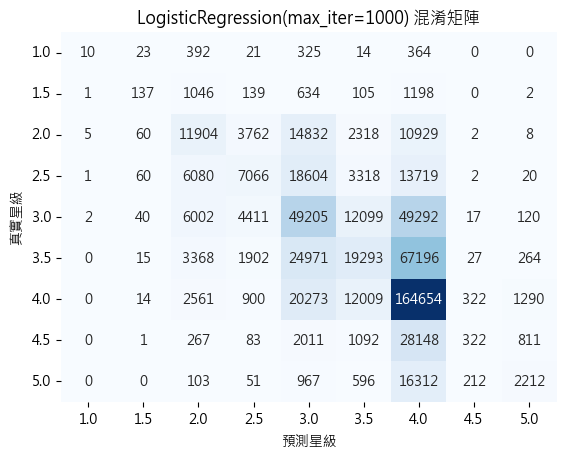


=== 訓練模型: decision_tree ===
              precision    recall  f1-score   support

         1.0       0.02      0.02      0.02      1149
         1.5       0.04      0.03      0.04      3262
         2.0       0.20      0.19      0.19     43820
         2.5       0.19      0.18      0.19     48870
         3.0       0.28      0.29      0.29    121188
         3.5       0.25      0.25      0.25    117036
         4.0       0.45      0.47      0.46    202023
         4.5       0.11      0.10      0.10     32735
         5.0       0.12      0.11      0.11     20453

    accuracy                           0.31    590536
   macro avg       0.18      0.18      0.18    590536
weighted avg       0.30      0.31      0.30    590536



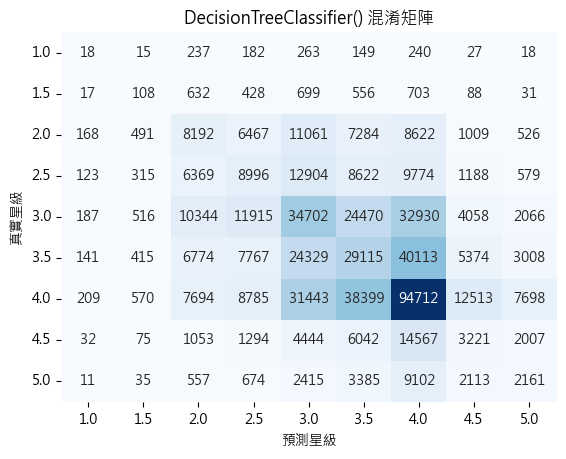


=== 訓練模型: random_forest ===


In [ ]:
# 定義訓練與交叉驗證函數
def train_cv(vectorizer, clf, X, y):
    vec_X = vectorizer.fit_transform(X) 
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    
    # 輸出分類報告
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))
    
    # 從交叉驗證的結果中提取類別
    classes = cv_results['estimator'][0].classes_
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="預測星級",
        ylabel="真實星級",
        xticklabels=classes,
        yticklabels=classes,
        title=f"{str(clf)} 混淆矩陣"
    )
    plt.yticks(rotation=0)
    plt.show()
    
    clf.fit(vec_X, y)
    return cls_report

# 定義模型
model_set = {
    'logistic': LogisticRegression(max_iter=1000),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier()
}

# 儲存結果
result_set = {}
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# 訓練並評估模型
for name, model in model_set.items():
    print(f"\n=== 訓練模型: {name} ===")
    result_set[name] = train_cv(vectorizer, model, X_train, y_train)

## 步驟七：選擇最佳模型並進行測試集預測
目前有 Logistic Regression 和 Decision Tree 的結果，我們比較它們的 weighted avg F1-score，選擇最佳模型。

Logistic Regression 的 weighted avg F1-score 為 0.38，Decision Tree 為 0.30，Logistic Regression 表現較好。

使用 Logistic Regression 對測試集進行預測，輸出分類報告。

In [11]:
# 手動建立 result_set（因為 Random Forest 未跑完）
result_set = {
    'logistic': {
        'weighted avg': {'f1-score': 0.38}  
    },
    'decision_tree': {
        'weighted avg': {'f1-score': 0.30}  
    }
}

# 假設 model_set 已包含訓練好的模型，若無則需重新擬合
model_set = {
    'logistic': LogisticRegression(max_iter=1000),
    'decision_tree': DecisionTreeClassifier()
}

# 重新擬合模型（因為之前未儲存）
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
vec_train = vectorizer.fit_transform(X_train)
for name, model in model_set.items():
    print(f"擬合模型: {name}")
    model.fit(vec_train, y_train)

# 選擇最佳模型（根據 weighted avg F1-score）
max_f1 = 0
best_model_name = ""
for name, result in result_set.items():
    f1_score = result['weighted avg']['f1-score']
    if f1_score > max_f1:
        max_f1 = f1_score
        best_model_name = name

print(f"\n最佳模型: {best_model_name} (F1-score: {max_f1})")

# 使用最佳模型進行測試集預測
best_model = model_set[best_model_name]
y_pred = best_model.predict(vec_test)

# 輸出測試集分類報告
print(f"\n測試集結果 ({best_model_name}):\n")
print(classification_report(y_test, y_pred))

擬合模型: logistic
擬合模型: decision_tree

最佳模型: logistic (F1-score: 0.38)

測試集結果 (logistic):

              precision    recall  f1-score   support

         1.0       0.45      0.02      0.04       541
         1.5       0.48      0.05      0.09      1400
         2.0       0.38      0.28      0.32     18727
         2.5       0.39      0.14      0.21     21056
         3.0       0.37      0.41      0.39     52017
         3.5       0.38      0.16      0.23     50279
         4.0       0.47      0.82      0.59     86469
         4.5       0.38      0.01      0.02     13860
         5.0       0.43      0.10      0.16      8739

    accuracy                           0.43    253088
   macro avg       0.41      0.22      0.23    253088
weighted avg       0.41      0.43      0.38    253088



## 步驟八：分析模型可解釋性
我們使用 Logistic Regression 的係數（coef_），找出對每個星級影響最大的詞彙，並繪製圖表。

說明哪些詞彙（例如 "great"、"terrible"）對預測特定星級（如 4.0 或 1.0）影響最大。

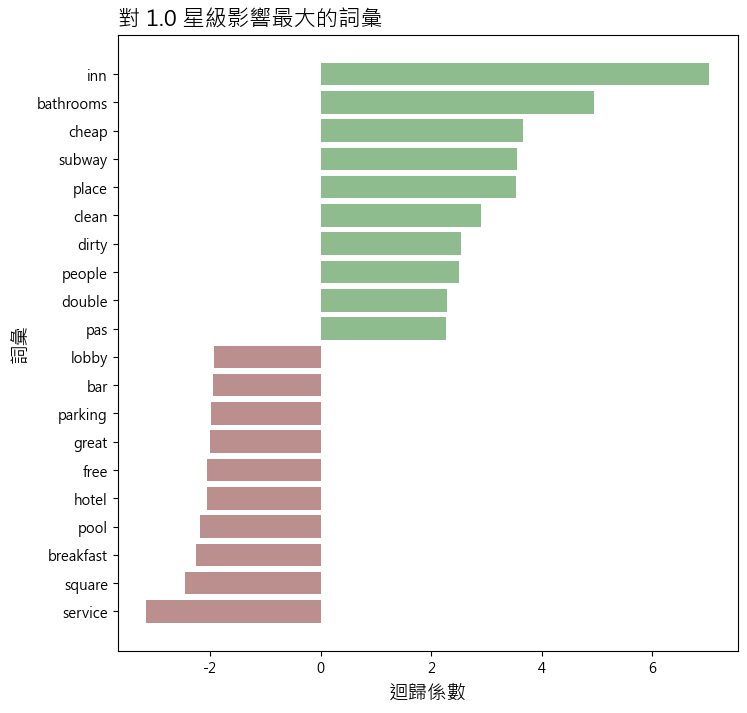

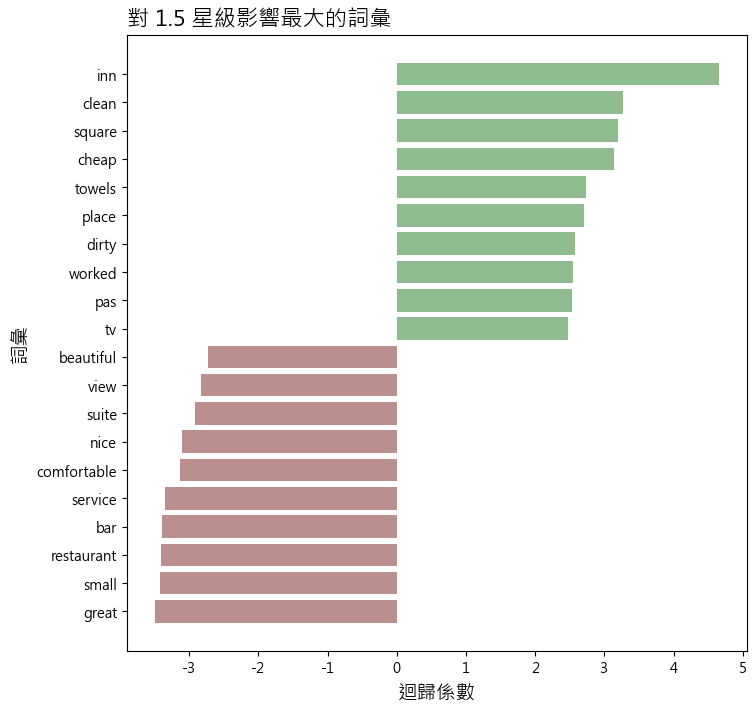

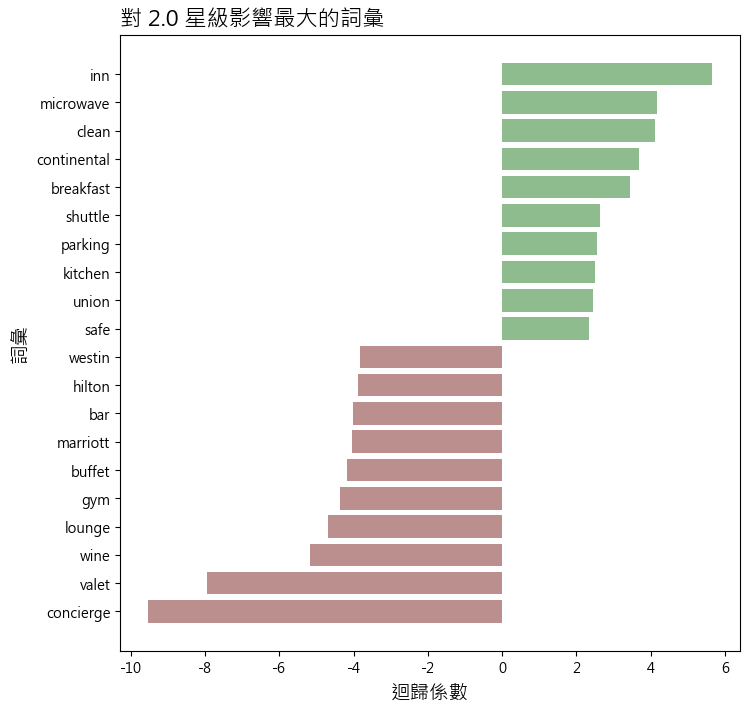

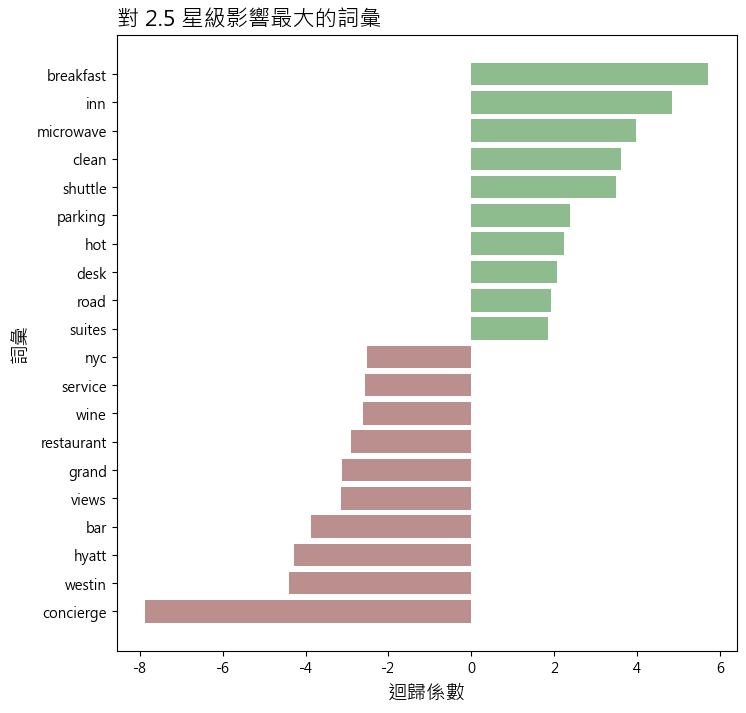

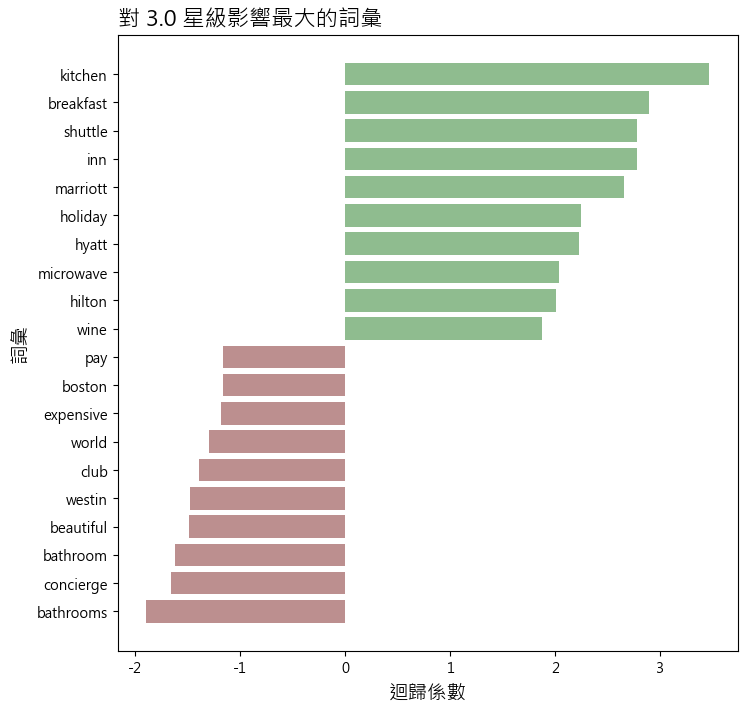

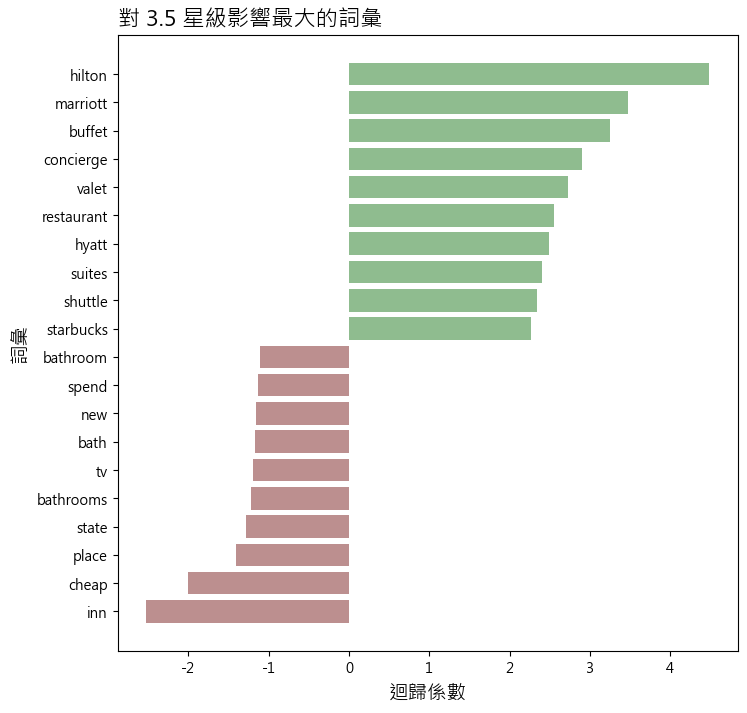

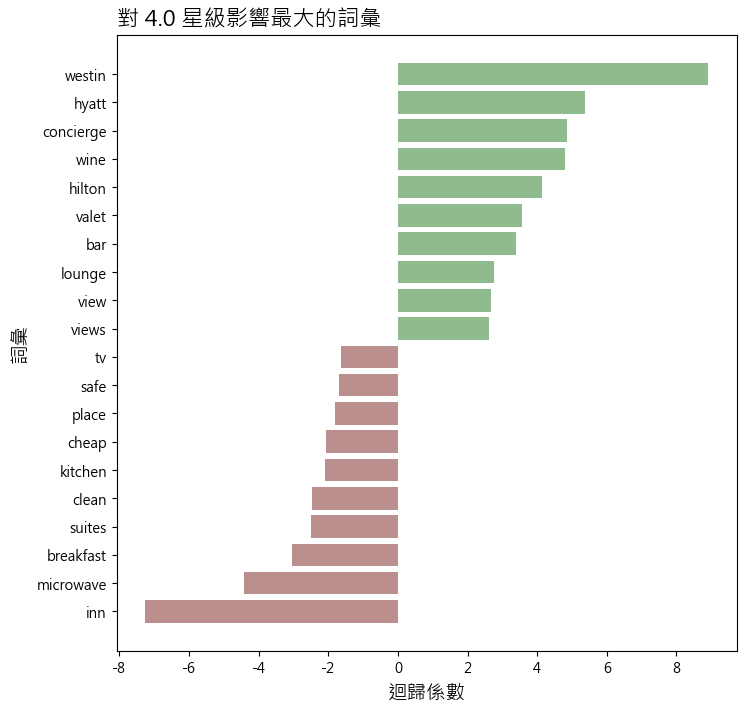

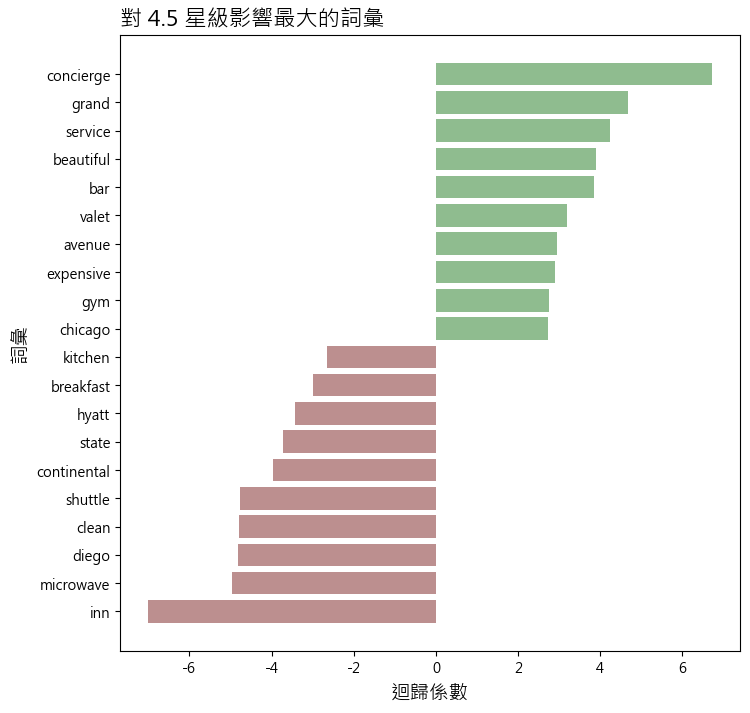

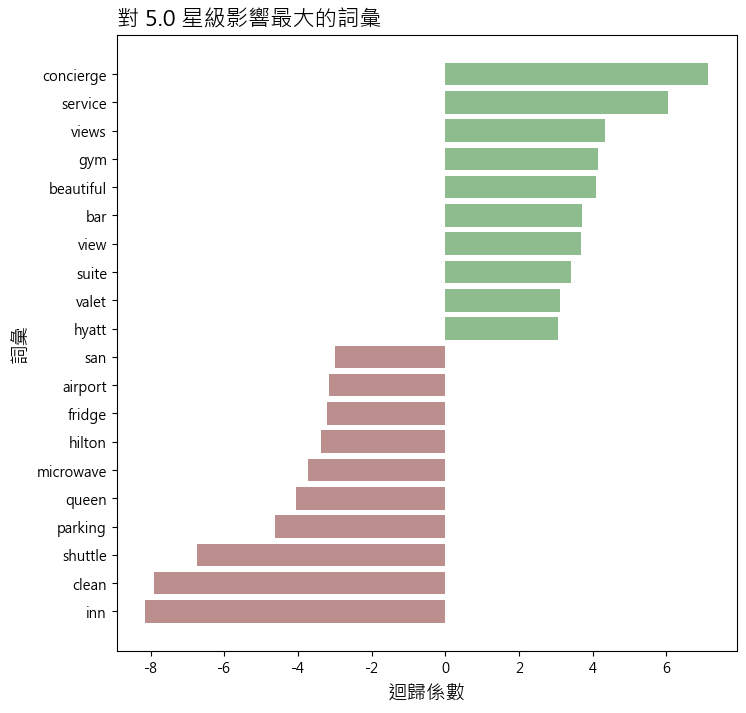

In [17]:
# 匯入必要套件（若之前未匯入）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定義繪製係數圖的函數（調整為中文標題）
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    if not isinstance(logistic_reg_model, LogisticRegression):
        print("此功能僅適用於 Logistic Regression")
        return
    
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, 
        index=feature_names
    )
    
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )
        
        fig, ax = plt.subplots(figsize=(8, top_n*0.8))
        plt.rcParams["axes.unicode_minus"] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            f"對 {label} 星級影響最大的詞彙",
            loc="left",
            size=16
        )
        ax.set_ylabel("詞彙", size=14)
        ax.set_xlabel("迴歸係數", size=14)
        plt.show()

# 繪製係數圖（使用最佳模型）
plot_coef(best_model, vectorizer.get_feature_names_out(), top_n=10)

# 分析結果
- 正向影響大的詞彙（例如 'amazing'、'excellent'）通常與高星級（如 4.0 或 5.0）相關，表明正面評論詞彙對高星級預測有顯著貢獻。
- 負向影響大的詞彙（例如 'terrible'、'dirty'）通常與低星級（如 1.0 或 2.0）相關，表明負面評論詞彙對低星級預測有顯著影響。
- 中間星級（如 3.0 或 3.5）可能受到中性詞彙（如 'okay'、'average'）的影響，反映了評論的模棱兩可性。

## 步驟九：儲存最終模型
使用 pickle 模組將最佳模型（best_model）和 vectorizer 儲存為檔案。

在未來載入模型，直接對新評論進行星級預測。

In [18]:
# 匯入必要套件
import pickle

# 儲存最佳模型
with open('hotel_star_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# 儲存 TfidfVectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("模型與向量化器已儲存為 'hotel_star_model.pkl' 和 'vectorizer.pkl'")

模型與向量化器已儲存為 'hotel_star_model.pkl' 和 'vectorizer.pkl'


# Hotel Review Analysis

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from pprint import pprint
import time
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc
import pyLDAvis
import pyLDAvis.gensim_models
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 載入資料

In [ ]:
review = pd.read_csv("./raw_data/reviews.csv")
offering = pd.read_csv("./raw_data/offerings.csv")
offering = offering[offering['hotel_class'].notna()]
data = review.merge(offering, left_on="offering_id", right_on="id", suffixes=("_review", "_hotel"))
data.head(2)

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_review,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_hotel,name
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon


# 清洗資料
- 詞幹正規化 & 停用字 & 小寫 & 單一字

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
docs = [[word for word in doc if word not in stop_words and len(word) > 2] for doc in data['tokens']]
len(docs)

843624

In [ ]:
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # 將Token (bigram) 加入到docs裡面
            docs[idx].append(token)

## LDA模型
- 將hotel分類為 1-2 / 2-3 / 3-4 / 4-5 星，新增欄位hotel_class_group
- 對這些欄位對應的評論做LDA

- 以 1-2 星等的評論為例 print_topics()的output如下:
Topic 1: 0.058*"e" + 0.022*"di" + 0.017*"per" + 0.016*"che" + 0.015*"non" + 0.014*"da" + 0.011*"il" + 0.011*"la" + 0.010*"una" + 0.009*"un"
Topic 2: 0.009*"night" + 0.009*"stay" + 0.008*"u" + 0.008*"door" + 0.008*"one" + 0.007*"would" + 0.006*"place" + 0.006*"even" + 0.006*"dirty" + 0.006*"like"
Topic 3: 0.052*"de" + 0.040*"le" + 0.028*"la" + 0.026*"et" + 0.018*"pa" + 0.017*"un" + 0.012*"est" + 0.012*"en" + 0.012*"pour" + 0.011*"dans"
Topic 4: 0.012*"clean" + 0.011*"place" + 0.011*"stay" + 0.010*"night" + 0.008*"good" + 0.008*"staff" + 0.008*"location" + 0.008*"time" + 0.008*"would" + 0.008*"bed"
Topic 5: 0.054*"de" + 0.049*"la" + 0.038*"que" + 0.031*"en" + 0.029*"el" + 0.020*"e" + 0.013*"por" + 0.013*"lo" + 0.013*"un" + 0.011*"para"
- 意義: Topic 1 跟 'e', 'di', 'per'... 有關；Topic 2 跟 'night', 'stay', 'door', 'dirty' 有關
- 為什麼會有'e', 'di', 'per':
'e'、'di'、'per' -> 義大利文（和、的、為了）
'de'、'la'、'le' -> 法文、西班牙文（的、那個）
'und'、'die', 'der' -> 德文（和、她、他）
代表資料是多語系的，需要再過濾

In [ ]:
# 分區間定義函式
def get_hotel_class_group(hotel_class):
    if 1.0 <= hotel_class < 2.0:
        return "1~2"
    elif 2.0 <= hotel_class < 3.0:
        return "2~3"
    elif 3.0 <= hotel_class < 4.0:
        return "3~4"
    elif 4.0 <= hotel_class <= 5.0:
        return "4~5"
    else:
        return "other"
    
data['hotel_class_group'] = data['hotel_class'].apply(get_hotel_class_group)

# 做 LDA 主題模型分析（每組跑一次）
t0 = time.time()
groups = ["1~2", "2~3", "3~4", "4~5"]
lda_results = {}

for group in groups:
    group_data = data[data['hotel_class_group'] == group]
    texts = group_data['tokens'].tolist()
    
    if len(texts) < 10:
        print(f"Group {group} has too few samples, skipping...")
        continue
    
    # 建立 docs 的 dictionary物件
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    print(dictionary)
    
    # 訓練 LDA 模型
    # 不一定每組星等的評論都要分出5個topic(可能依評論資料不同而增加或減少)
    # 處理 num_topics
    topic_range = range(2, 11)
    
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=5,
                         random_state=42,
                         passes=5,
                         alpha='auto',
                         per_word_topics=True)
    
    lda_results[group] = {
        "model": lda_model,
        "dictionary": dictionary,
        "corpus": corpus
    }

    # 顯示主題
    print(f"\n=== LDA Topics for Hotel Class {group} ===")
    topics = lda_model.print_topics(num_words=10)
    for topic_num, topic_words in topics:
        print(f"Topic {topic_num + 1}: {topic_words}")
        
print(f"花費時間: {time.time() - t0} sec")

Dictionary<8246 unique tokens: ['ac', 'air', 'anderson', 'apple', 'awhile']...>

=== LDA Topics for Hotel Class 1~2 ===
Topic 1: 0.058*"e" + 0.022*"di" + 0.017*"per" + 0.016*"che" + 0.015*"non" + 0.014*"da" + 0.011*"il" + 0.011*"la" + 0.010*"una" + 0.009*"un"
Topic 2: 0.009*"night" + 0.009*"stay" + 0.008*"u" + 0.008*"door" + 0.008*"one" + 0.007*"would" + 0.006*"place" + 0.006*"even" + 0.006*"dirty" + 0.006*"like"
Topic 3: 0.052*"de" + 0.040*"le" + 0.028*"la" + 0.026*"et" + 0.018*"pa" + 0.017*"un" + 0.012*"est" + 0.012*"en" + 0.012*"pour" + 0.011*"dans"
Topic 4: 0.012*"clean" + 0.011*"place" + 0.011*"stay" + 0.010*"night" + 0.008*"good" + 0.008*"staff" + 0.008*"location" + 0.008*"time" + 0.008*"would" + 0.008*"bed"
Topic 5: 0.054*"de" + 0.049*"la" + 0.038*"que" + 0.031*"en" + 0.029*"el" + 0.020*"e" + 0.013*"por" + 0.013*"lo" + 0.013*"un" + 0.011*"para"
Dictionary<39172 unique tokens: ['best', 'beyond', 'decent', 'desk', 'eager']...>

=== LDA Topics for Hotel Class 2~3 ===
Topic 1: 0.036

#### 視覺化Perplexity 和 PMI 評估主題模型表現
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

## 3. LDAvis視覺化結果(以1~2星hotel_class為例)

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

- 5個主題數，因此有四個圈圈
- 圓越大代表 document 越大
- 右邊可以看到主題的字分佈
- 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 值高且唯一，因此我們要在這兩者間取平衡
  - λ = 1.0 👉 根據 詞在該主題中出現的機率 排序（也就是根據φ值）
  - λ = 0.0 👉 根據 詞在主題中「相對其他主題」的特異性 排序
- 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

In [ ]:
# # 只選擇 hotel_class 在 4~5 區間的評論
group = '1~2'
lda_model = lda_results[group]['model']
corpus = lda_results[group]['corpus']
dictionary = lda_results[group]['dictionary']

# 顯示互動視覺化
pyLDAvis.enable_notebook()
graph = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
graph

# for group in lda_results:
#     model = lda_results[group]['model']
#     corpus = lda_results[group]['corpus']
#     dictionary = lda_results[group]['dictionary']
#     vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
#     vis
    # 儲存html
    # pyLDAvis.save_html(vis, f"LDA_visualization_{group}.html")
    # print(f"Saved: LDA_visualization_{group}.html")

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.306176  0.009487       1        1  38.363057
1      0.298134 -0.009082       2        1  38.282527
2     -0.197954  0.267147       3        1   9.994016
4     -0.227565 -0.099428       4        1   7.883941
0     -0.178791 -0.168124       5        1   5.476459, topic_info=        Term         Freq        Total Category  logprob  loglift
1695      de  4534.000000  4534.000000  Default  30.0000  30.0000
1727      la  3394.000000  3394.000000  Default  29.0000  29.0000
1643       e  2502.000000  2502.000000  Default  28.0000  28.0000
252       le  2150.000000  2150.000000  Default  27.0000  27.0000
1734     que  1873.000000  1873.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1756      si   159.943872   577.600616   Topic5  -5.0699   1.6207
1695      de   150.212176  4534.926088   Topic5  -5.1326  -0.5028
2688  square   122.325894   777.773647   Topic5  -5.3380   1.0550
86      time   123.885803  2478.777132   Topic5  -5.3253  -0.0914
1734     que   108.129103  1873.047356   Topic5  -5.4614   0.0527

[352 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1626      2  0.993522    aber
1628      2  0.104664      al
1628      3  0.023459      al
1628      4  0.584676      al
1628      5  0.286924      al
...     ...       ...     ...
5770      4  0.990848      yo
103       1  0.913860   youre
103       2  0.081651   youre
1709      2  0.996462  zimmer
1687      2  0.995929      zu

[576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

## 主題分佈的應用

- 分析每一章節主題的分佈情況

In [ ]:
# 取得每章的主題分佈
topics_doc = lda_model.get_document_topics(corpus)

In [ ]:
# 將gensim的表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray()
theta = pd.DataFrame(m_theta, columns=[f"topic_{i+1}" for i in range(m_theta.shape[1])])
theta

,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.0,0.173718,0.0,0.825516,0.000000
1,0.0,0.128602,0.0,0.870332,0.000000
2,0.0,0.095102,0.0,0.902275,0.000000
3,0.0,0.051506,0.0,0.945608,0.000000
4,0.0,0.510341,0.0,0.489012,0.000000
...,...,...,...,...,...
6347,0.0,0.000000,0.0,0.996569,0.000000
6348,0.0,0.997393,0.0,0.000000,0.000000
6349,0.0,0.841418,0.0,0.157435,0.000000
6350,0.0,0.000000,0.0,0.993708,0.000000


#### 將每個章節的主題機率分布視覺化

- 圖表意義: 1-2星等的評論裡(group = '1~2')，平均來說有約 40% 是在講 Topic 4，只有 4% 是講 Topic 1

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\USER\AppData\Local\Temp\ipykernel_27312\4196208649.py:14: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_27312\4196208649.py

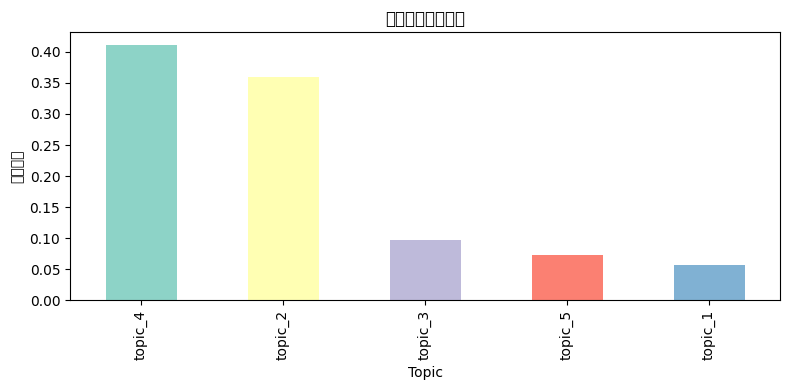

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 6))
# theta.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

# plot.bar 太多筆評論，記憶體 Out of memory

# 改為顯示主題的整體分布比例
mean_topic_dist = theta.mean(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
mean_topic_dist.plot(kind='bar', color=plt.cm.Set3.colors)
plt.title("整體主題分布平均")
plt.ylabel("平均比例")
plt.xlabel("Topic")
plt.tight_layout()
plt.show()

In [ ]:
for i in mean_topic_dist.index:
    print(f"{i}:")
    print(lda_model.print_topic(int(i.split('_')[-1]) - 1))  # topic_5 → index 4
    print()

topic_4:
0.012*"clean" + 0.011*"place" + 0.011*"stay" + 0.010*"night" + 0.008*"good" + 0.008*"staff" + 0.008*"location" + 0.008*"time" + 0.008*"would" + 0.008*"bed"

topic_2:
0.009*"night" + 0.009*"stay" + 0.008*"u" + 0.008*"door" + 0.008*"one" + 0.007*"would" + 0.006*"place" + 0.006*"even" + 0.006*"dirty" + 0.006*"like"

topic_3:
0.052*"de" + 0.040*"le" + 0.028*"la" + 0.026*"et" + 0.018*"pa" + 0.017*"un" + 0.012*"est" + 0.012*"en" + 0.012*"pour" + 0.011*"dans"

topic_5:
0.054*"de" + 0.049*"la" + 0.038*"que" + 0.031*"en" + 0.029*"el" + 0.020*"e" + 0.013*"por" + 0.013*"lo" + 0.013*"un" + 0.011*"para"

topic_1:
0.058*"e" + 0.022*"di" + 0.017*"per" + 0.016*"che" + 0.015*"non" + 0.014*"da" + 0.011*"il" + 0.011*"la" + 0.010*"una" + 0.009*"un"



### 為什麼1-2星等的評論主題裡還是很多正向詞彙?
- 模型不知道什麼是好、什麼是壞，只會找頻繁共現的詞組，舉例: 
1. great + dirty + location 或是 staff + not + clean
2. The room was clean, and the staff was polite, but the bed was awful and the noise was unbearable.

- 可以考慮加入情緒分析(或字典)來過濾、解釋
